In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import trange, tqdm

In [2]:
batch_size = 256
dataset_dir = '../data'

train_data = MNIST(dataset_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(dataset_dir, train=False, download=True, transform=transforms.ToTensor())

train_loader = dataloader.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [3]:
GPU_index = 0
device = torch.device(f'cuda:{GPU_index}' if torch.cuda.is_available() else 'cpu')

In [4]:
images, labels = next(iter(train_loader))
print("The input data shape is:", images.shape)
print("The target output data shape is:", labels.shape)

The input data shape is: torch.Size([256, 1, 28, 28])
The target output data shape is: torch.Size([256])


In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, num_classes=2, img_size=2*2):
        super(SimpleMLP, self).__init__()
        self.fc_0 = nn.Linear(img_size, 512)
        self.fc_1 = nn.Linear(512, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_output = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc_0(x))
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_output(x)
        return x

In [6]:
model = SimpleMLP(num_classes=10, img_size=28*28).to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 20

print(model)

SimpleMLP(
  (fc_0): Linear(in_features=784, out_features=512, bias=True)
  (fc_1): Linear(in_features=512, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (fc_output): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
def train_epoch(model, train_loader, criterion, optimizer, loss_logger):
    for _, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        outputs = model(data.to(device))
        loss = criterion(outputs, target.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

In [8]:
def test_model(model, test_loader, criterion, loss_logger):
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        
        for _, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            outputs = model(data.to(device))

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == target.to(device)).sum().item()
            total_predictions += target.shape[0]

            loss = criterion(outputs, target.to(device))
            loss_logger.append(loss.item())

            accuracy = correct_predictions / total_predictions
    
        return accuracy, loss_logger

In [9]:
train_loss = []
test_loss = []
test_accuracy = []

In [10]:
for i in trange(num_epochs, desc="Epoch"):
    model, optimizer, train_loss = train_epoch(model, train_loader, criterion, optimizer, train_loss)
    accuracy, test_loss = test_model(model, test_loader, criterion, test_loss)
    test_accuracy.append(accuracy)

print(f"Final accuracy: {test_accuracy[-1]:.2f}")

Final accuracy: 0.98


In [18]:
def plot_subplot(ax, title, xlabel, ylabel, data):
    ax.plot(data)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot(subplot_data):
    _, axs = plt.subplots(1, len(subplot_data), figsize=(20, 5))
    for i, (title, xlabel, ylabel, data) in enumerate(subplot_data):
        plot_subplot(axs[i], title, xlabel, ylabel, data)
    plt.show()

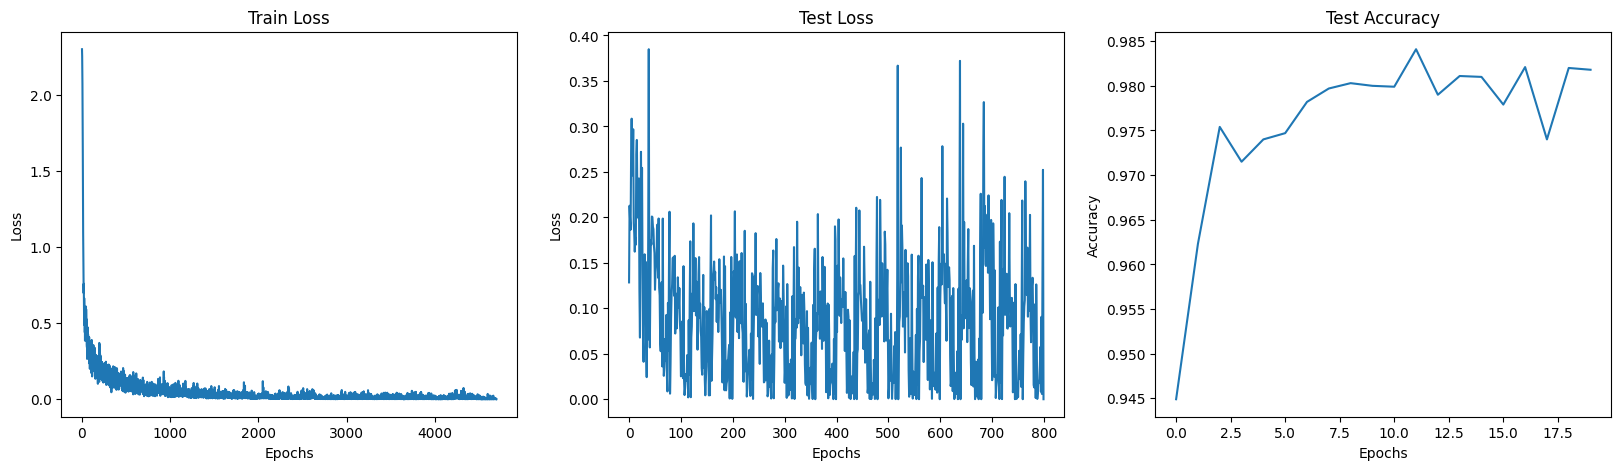

In [20]:

plot([
    ["Train Loss", "Epochs", "Loss", train_loss],
    ["Test Loss", "Epochs", "Loss", test_loss],
    ["Test Accuracy", "Epochs", "Accuracy", test_accuracy]
])
